In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import pymc as pm
import xarray as xr

from scipy import special

from utils import WGBP, LogisticFamily

## Gambia

### The model

$$
\begin{aligned}
Y_i \mid \pi_i &\sim \text{Bernoulli}(\pi_i) \\
\text{logit}(\pi_i) = \eta_i &= \alpha + {\bf X}_i\boldsymbol\beta+\gamma_{g[i]} \\
\alpha &\sim \text{Normal}(\mu_0, \tau_0^2) \\
\boldsymbol{\beta} &\sim \text{Normal}(0, \frac{1}{5} \phi_1 W \mathbf{I})  \\
\boldsymbol{\gamma} &\sim \text{Normal}(0, \phi_2 W \mathbf{C}) \\
\rho &\sim \text{Uniform}(0, 2r) \\
W &\sim \text{GBP}(a^*, b^*, c^*, d^*) \\
(\phi_1, \phi_2) &\sim \text{Dirichlet}(\xi_1, \xi_2)
\end{aligned}
$$

we assume

$$
\begin{aligned}
\mathbb{E}(\gamma_i) &= 0 \\
\mathbb{V}(\gamma_i) &= \sigma^2_\gamma & \text{for all } i \\
C_{ij} &= \text{Cor}(\gamma_i, \gamma_j) = e^{-d_{ij} / \rho} \\
\end{aligned}
$$

where $d_{ij}$ is the distance between village $i$ and $j$, and $\rho > 0$ is the spatial range parameter.

* $\mu_0 = 0$
* $\tau_0^2 = 3$ --> I'm actually changing this a bit, too wide
* $\xi_1 = \xi_2 = 1$
* $r$ is the maximum distance between pairs of villages.

In [2]:
df = pl.read_csv("gambia.csv")
df

x,y,pos,age,netuse,treated,green,phc
f64,i64,i64,i64,i64,i64,f64,i64
349631.3,1458055,1,1783,0,0,40.85,1
349631.3,1458055,0,404,1,0,40.85,1
349631.3,1458055,0,452,1,0,40.85,1
349631.3,1458055,1,566,1,0,40.85,1
349631.3,1458055,0,598,1,0,40.85,1
…,…,…,…,…,…,…,…
622086.1,1474011,1,1705,1,0,50.1,1
622086.1,1474011,1,1704,1,0,50.1,1
622086.1,1474011,1,1733,0,0,50.1,1


In [3]:
df_locations = df.select("x", "y").unique(maintain_order=True).with_columns(location=pl.row_index())
df_locations

x,y,location
f64,i64,u32
349631.3,1458055,0
358543.1,1460112,1
360308.1,1460026,2
363795.7,1496919,3
366400.5,1460248,4
…,…,…
613529.5,1473868,60
614665.6,1482815,61
614722.5,1474320,62


In [4]:
df = df.join(df_locations, on=["x", "y"])
df

x,y,pos,age,netuse,treated,green,phc,location
f64,i64,i64,i64,i64,i64,f64,i64,u32
349631.3,1458055,1,1783,0,0,40.85,1,0
349631.3,1458055,0,404,1,0,40.85,1,0
349631.3,1458055,0,452,1,0,40.85,1,0
349631.3,1458055,1,566,1,0,40.85,1,0
349631.3,1458055,0,598,1,0,40.85,1,0
…,…,…,…,…,…,…,…,…
622086.1,1474011,1,1705,1,0,50.1,1,64
622086.1,1474011,1,1704,1,0,50.1,1,64
622086.1,1474011,1,1733,0,0,50.1,1,64


In [5]:
y = df.get_column("pos").to_numpy()
X = df.select("age", "netuse", "treated", "green", "phc").to_numpy()
X_std = (X - X.mean(0)) / X.std(0)

location_idx = df.get_column("location").to_numpy()

In [6]:
def pl_scale(name):
    return (pl.col(name) - pl.col(name).mean()) / pl.col(name).std()


df_geo = (
    df.select("x", "y", "location").with_columns(x_std=pl_scale("x"), y_std=pl_scale("y"))
)
df_geo

x,y,location,x_std,y_std
f64,i64,u32,f64,f64
349631.3,1458055,0,-1.418594,-1.675692
349631.3,1458055,0,-1.418594,-1.675692
349631.3,1458055,0,-1.418594,-1.675692
349631.3,1458055,0,-1.418594,-1.675692
349631.3,1458055,0,-1.418594,-1.675692
…,…,…,…,…
622086.1,1474011,64,1.324388,-0.618882
622086.1,1474011,64,1.324388,-0.618882
622086.1,1474011,64,1.324388,-0.618882


In [7]:
X_geo_std = df_geo.select("x_std", "y_std").to_numpy()
X_geo_std

array([[-1.41859375, -1.6756917 ],
       [-1.41859375, -1.6756917 ],
       [-1.41859375, -1.6756917 ],
       ...,
       [ 1.32438789, -0.61888241],
       [ 1.32438789, -0.61888241],
       [ 1.32438789, -0.61888241]], shape=(2035, 2))

In [8]:
X_geo_std_unique = df_geo.select("x_std", "y_std").unique(maintain_order=True).to_numpy()
X_geo_std_unique[:5]

array([[-1.41859375, -1.6756917 ],
       [-1.3288728 , -1.53945099],
       [-1.31110339, -1.54514701],
       [-1.27599142,  0.89837675],
       [-1.24976719, -1.53044334]])

In [9]:
n = len(y)
p = X_std.shape[1]
q = 1
L = len(np.unique(location_idx))

n, p, q, L

(2035, 5, 1, 65)

In [64]:
family = LogisticFamily(a=2, b=8, intercept=special.logit(np.mean(y)))
params = WGBP(family)
params

array([3.45220389, 6.72368657, 0.72156864, 2.96020658])

In [65]:
from utils import gbp_pdf

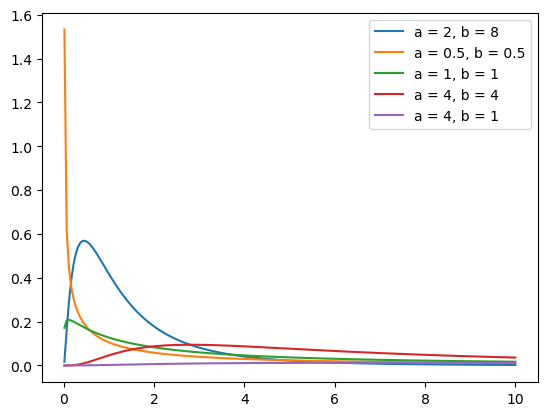

In [ ]:
params2 = [1.4722786, 0.6494361, 0.7887448, 1.6711417]

params_dict = {
    # "a = 1, b = 4":   [1.15, 2.08, 0.91, 2.09],
    # "a = 1, b = 4":   [1.36335635, 2.60432824, 0.81619041, 2.40698754],
    "a = 2, b = 8":   params,
    # "a = 0.5, b = 0.5": [0.57, 0.29, 0.90, 1.54],
    "a = 1, b = 1":   [1.47, 0.65, 0.79, 1.67],
    "a = 4, b = 4":   [7.45, 2.72, 0.73, 1.63],
    "a = 4, b = 1":   [7.77, 0.71, 0.68, 1.45],
}

fig, ax = plt.subplots()
x_grid = np.linspace(0.01, 10, num=200)

for key, values in params_dict.items():
    ax.plot(x_grid, gbp_pdf(x_grid, *values), label=key)

ax.legend();

In [68]:
# Compute pairwise squared distances
diff = X_geo_std_unique[:, None, :] - X_geo_std_unique[None, :, :] # shape (L, L, 2)
dist = np.sqrt(np.sum(diff**2, axis=-1))   # shape (L, L)
dist

array([[0.        , 0.16312995, 0.1691038 , ..., 2.8780668 , 3.77929302,
        2.93952277],
       [0.16312995, 0.        , 0.01866003, ..., 2.74543973, 3.62034261,
        2.80842283],
       [0.1691038 , 0.01866003, 0.        , ..., 2.73072311, 3.61136768,
        2.79352472],
       ...,
       [2.8780668 , 2.74543973, 2.73072311, ..., 0.        , 1.54501226,
        0.07690731],
       [3.77929302, 3.62034261, 3.61136768, ..., 1.54501226, 0.        ,
        1.56468451],
       [2.93952277, 2.80842283, 2.79352472, ..., 0.07690731, 1.56468451,
        0.        ]], shape=(65, 65))

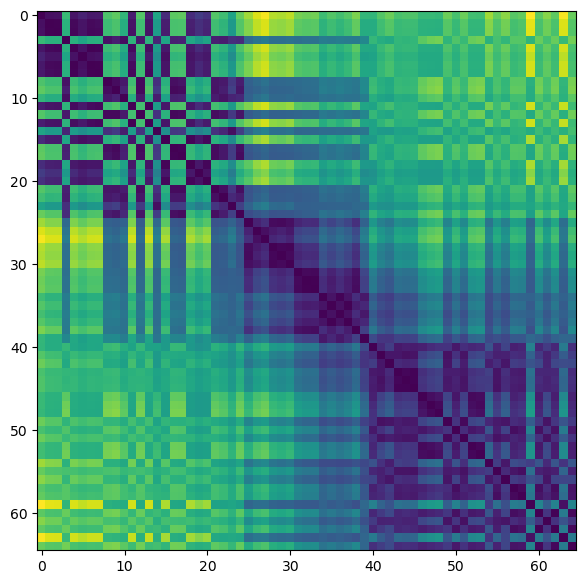

In [69]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(dist);

In [70]:
r = dist.max() # NOTE: why does the case study say 0.986?
#r = 0.986

In [71]:
params

array([3.45220389, 6.72368657, 0.72156864, 2.96020658])

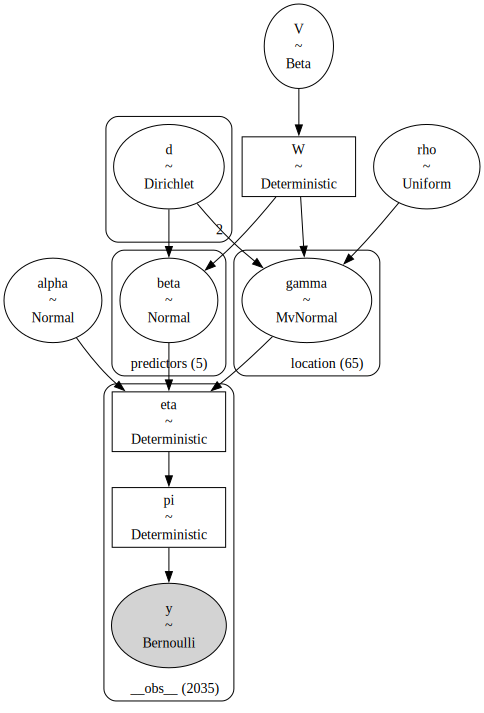

In [100]:
coords = {
    "__obs__": np.arange(len(y)),
    "predictors": ["age", "netuse", "treated", "green", "phc"],
    "location": np.unique(location_idx)
}

with pm.Model(coords=coords) as model:
    # Correlation matrix
    rho = pm.Uniform("rho", lower=0, upper=2 * r)
    C = np.exp(-dist / rho)

    V = pm.Beta("V", alpha=params[0], beta=params[1])
    W = pm.Deterministic("W", ((V / (1 - V)) ** (1 / params[2])) * params[3])

    d = pm.Dirichlet("d", a=np.ones(2))

    alpha = pm.Normal("alpha", mu=0, sigma=0.1 ** 0.5)
    beta = pm.Normal("beta", mu=0, sigma=((1 / p) * W * d[0]) ** 0.5, dims="predictors")

    # NOTE: Why does the paper don't do (1 / L)?
    gamma = pm.MvNormal("gamma", mu=0, cov=(1 / L) * d[1]  * W * C, dims="location")

    eta = pm.Deterministic("eta", alpha + X_std @ beta + gamma[location_idx], dims="__obs__")
    pi = pm.Deterministic("pi", pm.math.sigmoid(eta), dims="__obs__")

    pm.Bernoulli("y", p=pi, observed=y, dims="__obs__")

model.to_graphviz()

In [101]:
with model:
    idata = pm.sample_prior_predictive(draws=1000)

Sampling: [V, alpha, beta, d, gamma, rho, y]


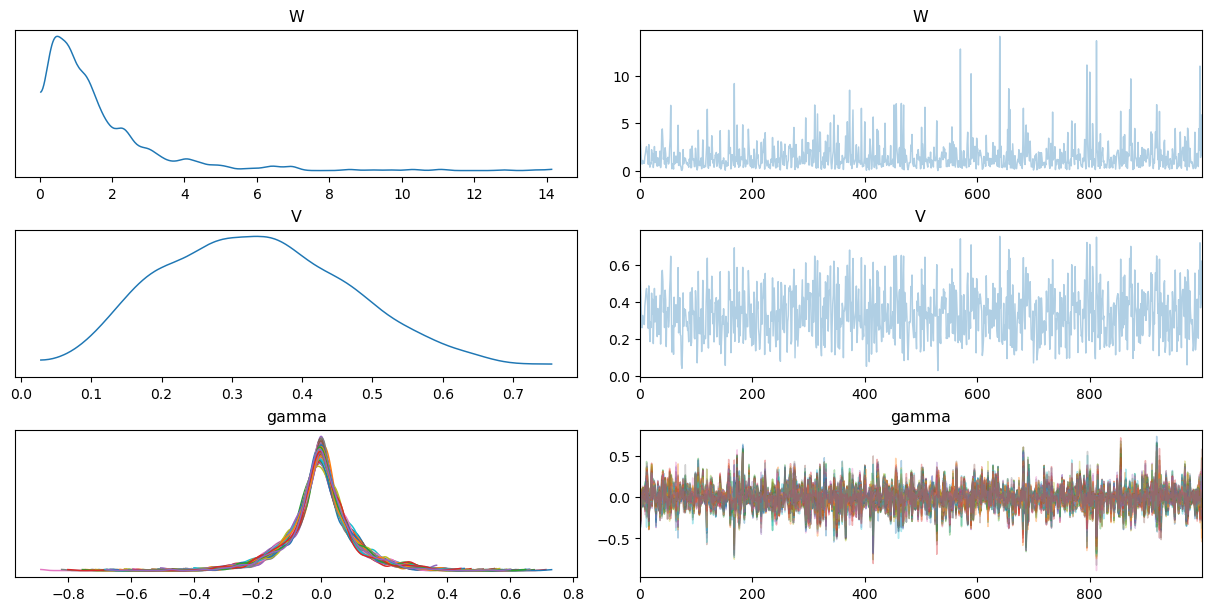

In [102]:
az.plot_trace(idata.prior, var_names=["W", "V", "gamma"], backend_kwargs={"layout": "constrained"});

In [98]:
with model:
    idata = pm.sample(target_accept=0.95, draws=1000, random_seed=1234)
    # idata.extend(pm.sample(target_accept=0.95, draws=1000, random_seed=1234))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho, V, d, alpha, beta, gamma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


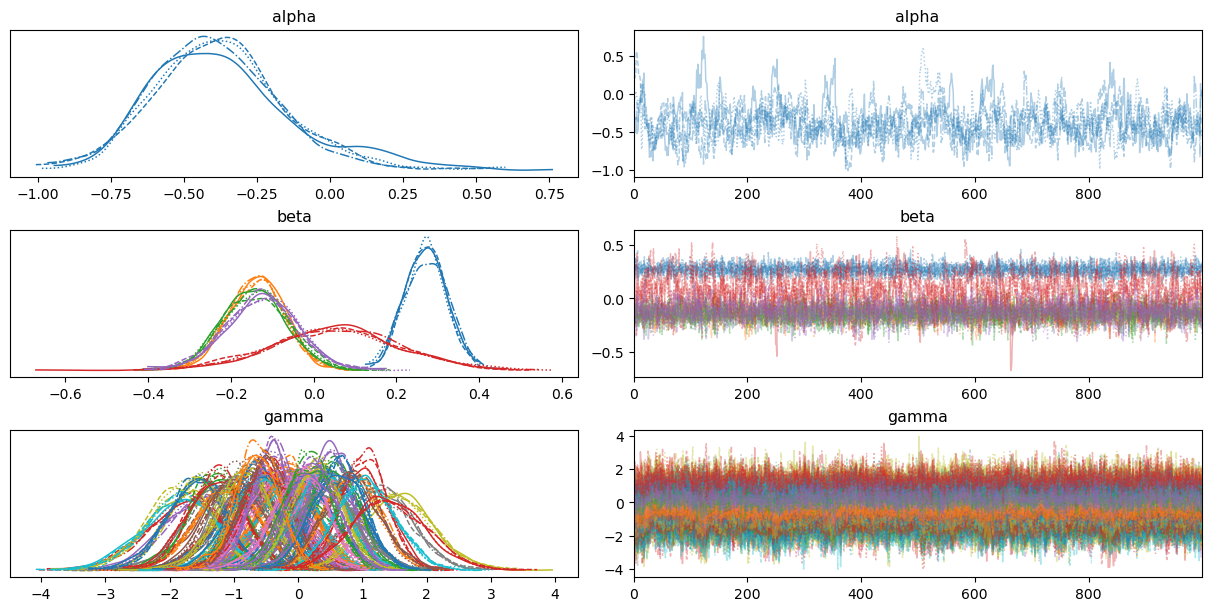

In [99]:
az.plot_trace(idata, var_names=["alpha", "beta", "gamma"], backend_kwargs={"layout": "constrained"});

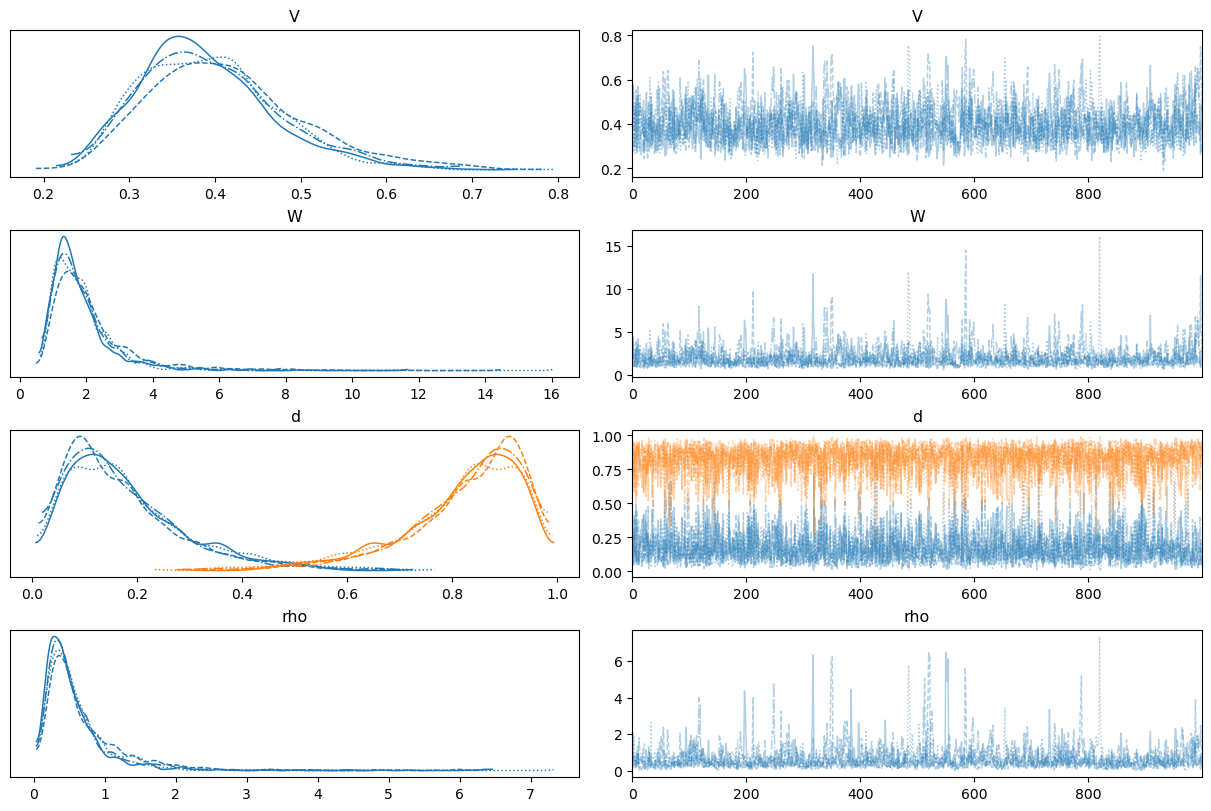

In [59]:
az.plot_trace(idata, var_names=["V", "W", "d", "rho"], backend_kwargs={"layout": "constrained"});

In [17]:
np.sort(xr.corr(idata.posterior.gamma, idata.posterior.alpha, dim=("chain", "draw")))

array([-0.88246662, -0.85666562, -0.85088575, -0.84887153, -0.80985629,
       -0.80866959, -0.8070555 , -0.80694738, -0.80601925, -0.80308131,
       -0.79812587, -0.7971818 , -0.79303341, -0.79254894, -0.79130086,
       -0.79009775, -0.7891987 , -0.78860546, -0.78315384, -0.78094428,
       -0.77999262, -0.77905001, -0.7774377 , -0.77661904, -0.77613537,
       -0.77241788, -0.77141149, -0.77136535, -0.77025449, -0.76950598,
       -0.76628581, -0.76483359, -0.76355989, -0.76233868, -0.76209835,
       -0.76112103, -0.76079182, -0.7601418 , -0.76000182, -0.75994347,
       -0.75843791, -0.75320862, -0.7498292 , -0.74854246, -0.74615967,
       -0.73657433, -0.73472434, -0.73408144, -0.73243776, -0.73109507,
       -0.72187408, -0.71999287, -0.7182408 , -0.71325378, -0.71167882,
       -0.70964979, -0.69304391, -0.66701208, -0.65733284, -0.6473122 ,
       -0.63854042, -0.625511  , -0.6125876 , -0.6056953 , -0.58842273])

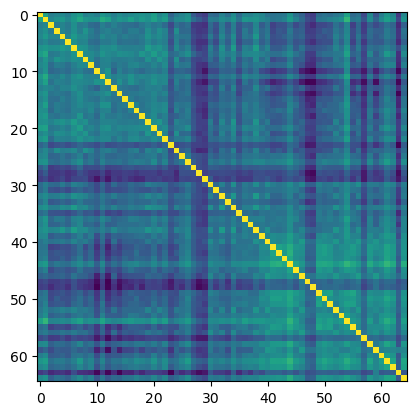

In [18]:
corr_matrix = np.corrcoef(idata.posterior.gamma.stack(sample=("chain", "draw")).to_numpy())

fig, ax = plt.subplots()
ax.imshow(corr_matrix);

In [19]:
np.linalg.eigvals(corr_matrix)

array([37.66569729,  3.05602002,  1.39709908,  0.93822144,  0.68288545,
        0.66356648,  0.60459236,  0.571364  ,  0.54680584,  0.53562665,
        0.52387685,  0.50819712,  0.50133059,  0.48640057,  0.47710439,
        0.46889125,  0.18006828,  0.45243311,  0.44359562,  0.43565993,
        0.19758833,  0.42596341,  0.20411253,  0.41867804,  0.41343702,
        0.40554661,  0.21552066,  0.39567326,  0.22266288,  0.38539375,
        0.37881054,  0.38082312,  0.22903864,  0.36783043,  0.36507435,
        0.23736743,  0.35991093,  0.35517957,  0.35136271,  0.34630342,
        0.34428837,  0.24490588,  0.24664052,  0.24898654,  0.25097348,
        0.33341411,  0.32919784,  0.32401231,  0.32482983,  0.25808209,
        0.26230233,  0.26238988,  0.26526626,  0.26965059,  0.27387659,
        0.27906475,  0.28169557,  0.28558547,  0.31386042,  0.31036192,
        0.3043089 ,  0.3028556 ,  0.30149167,  0.29356062,  0.2926845 ])

### Attemp 2

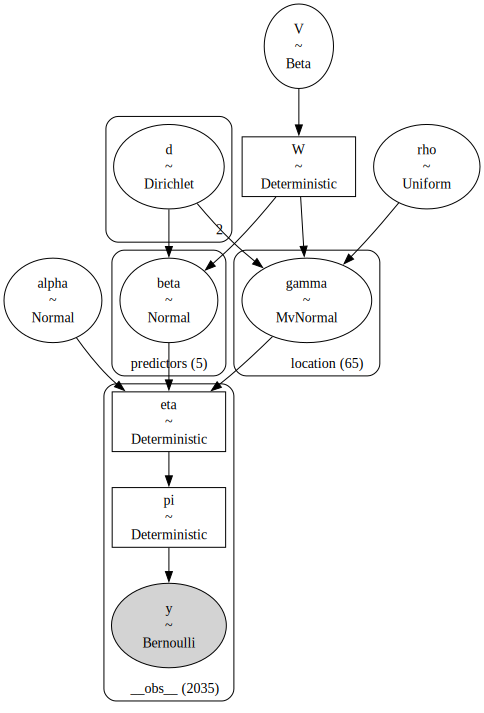

In [20]:
coords = {
    "__obs__": np.arange(len(y)),
    "predictors": ["age", "netuse", "treated", "green", "phc"],
    "location": np.unique(location_idx)
}

with pm.Model(coords=coords) as model_gambia_2:
    # Correlation matrix
    rho = pm.Uniform("rho", lower=0, upper=2 * r)
    C = np.exp(-dist / rho) + np.eye(65)

    V = pm.Beta("V", alpha=params[0], beta=params[1])
    W = pm.Deterministic("W", (V / (1 - V)) ** (1 / params[2]) * params[3])
    d = pm.Dirichlet("d", a=np.ones(2))

    alpha = pm.Normal("alpha", mu=0, sigma=0.3 ** 0.5)
    beta = pm.Normal("beta", mu=0, sigma=(1 / p * W * d[0]) ** 0.5, dims="predictors")

    gamma = pm.MvNormal("gamma", mu=0, cov=d[1] * W * C, dims="location")

    eta = pm.Deterministic("eta", alpha + X_std @ beta + gamma[location_idx], dims="__obs__")
    pi = pm.Deterministic("pi", pm.math.sigmoid(eta), dims="__obs__")

    pm.Bernoulli("y", p=pi, observed=y, dims="__obs__")

model_gambia_2.to_graphviz()

In [21]:
with model_gambia_2:
    idata_gambia_2 = pm.sample(target_accept=0.95, draws=1000, random_seed=1234)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho, V, d, alpha, beta, gamma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


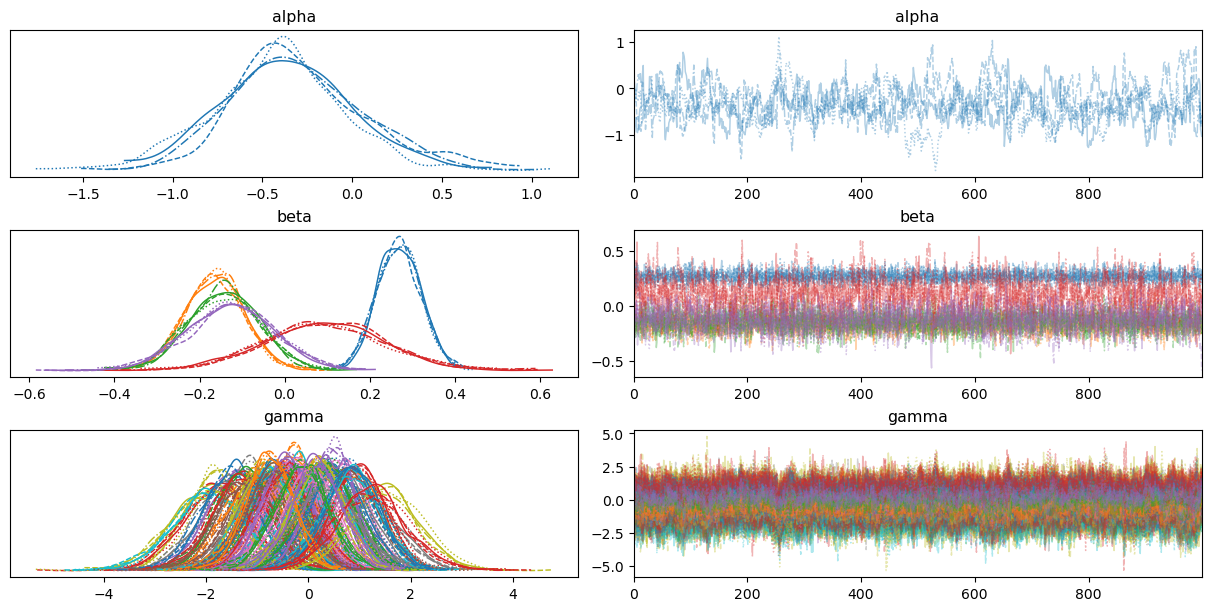

In [22]:
az.plot_trace(idata_gambia_2, var_names=["alpha", "beta", "gamma"], backend_kwargs={"layout": "constrained"});

In [23]:
np.sort(xr.corr(idata_gambia_2.posterior.gamma, idata_gambia_2.posterior.alpha, dim=("chain", "draw")))

array([-0.82137493, -0.78700414, -0.78401435, -0.77546544, -0.7344547 ,
       -0.73358241, -0.72374123, -0.72075968, -0.72043746, -0.71860512,
       -0.71234129, -0.71144524, -0.70852146, -0.70520835, -0.70435865,
       -0.70321846, -0.70104889, -0.69752793, -0.69669899, -0.69586671,
       -0.69479966, -0.69344106, -0.69224881, -0.69152504, -0.68889688,
       -0.68738293, -0.68737982, -0.6873158 , -0.6822692 , -0.68155675,
       -0.68058498, -0.67923546, -0.67674148, -0.6751441 , -0.67159847,
       -0.67067589, -0.66846683, -0.66786425, -0.66614009, -0.66519914,
       -0.66432009, -0.66192345, -0.66134147, -0.65237036, -0.65204052,
       -0.64680325, -0.63865077, -0.63530596, -0.6311754 , -0.62823728,
       -0.62600391, -0.62262117, -0.62189856, -0.61977196, -0.60756044,
       -0.60459877, -0.59326397, -0.58690642, -0.58009364, -0.54327576,
       -0.53178516, -0.52739345, -0.52714134, -0.50290016, -0.50205117])

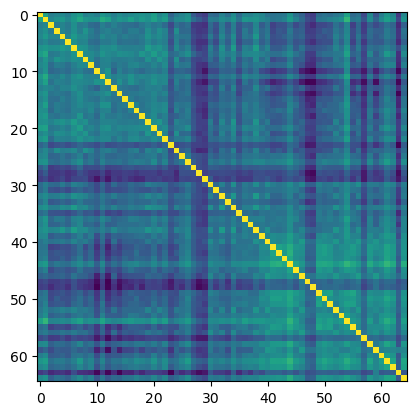

In [24]:
corr_matrix = np.corrcoef(idata.posterior.gamma.stack(sample=("chain", "draw")).to_numpy())

fig, ax = plt.subplots()
ax.imshow(corr_matrix);

In [25]:
np.linalg.eigvals(corr_matrix)

array([37.66569729,  3.05602002,  1.39709908,  0.93822144,  0.68288545,
        0.66356648,  0.60459236,  0.571364  ,  0.54680584,  0.53562665,
        0.52387685,  0.50819712,  0.50133059,  0.48640057,  0.47710439,
        0.46889125,  0.18006828,  0.45243311,  0.44359562,  0.43565993,
        0.19758833,  0.42596341,  0.20411253,  0.41867804,  0.41343702,
        0.40554661,  0.21552066,  0.39567326,  0.22266288,  0.38539375,
        0.37881054,  0.38082312,  0.22903864,  0.36783043,  0.36507435,
        0.23736743,  0.35991093,  0.35517957,  0.35136271,  0.34630342,
        0.34428837,  0.24490588,  0.24664052,  0.24898654,  0.25097348,
        0.33341411,  0.32919784,  0.32401231,  0.32482983,  0.25808209,
        0.26230233,  0.26238988,  0.26526626,  0.26965059,  0.27387659,
        0.27906475,  0.28169557,  0.28558547,  0.31386042,  0.31036192,
        0.3043089 ,  0.3028556 ,  0.30149167,  0.29356062,  0.2926845 ])

### Attempt 3

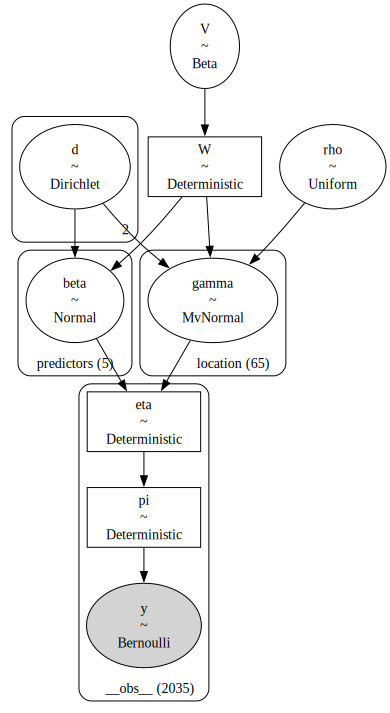

In [ ]:
coords = {
    "__obs__": np.arange(len(y)),
    "predictors": ["age", "netuse", "treated", "green", "phc"],
    "location": np.unique(location_idx)
}

with pm.Model(coords=coords) as model_gambia_3:
    # Correlation matrix
    rho = pm.Uniform("rho", lower=0, upper=2 * r)
    C = np.exp(-dist / rho) + np.eye(65)

    V = pm.Beta("V", alpha=params[0], beta=params[1])
    W = pm.Deterministic("W", (V / (1 - V)) ** (1 / params[2]) * params[3])
    d = pm.Dirichlet("d", a=np.ones(2))

    beta = pm.Normal("beta", mu=0, sigma=(1 / p * W * d[0]) ** 0.5, dims="predictors")
    gamma = pm.MvNormal("gamma", mu=0, cov=d[1] * W * C, dims="location")

    eta = pm.Deterministic("eta", X_std @ beta + gamma[location_idx], dims="__obs__")
    pi = pm.Deterministic("pi", pm.math.sigmoid(eta), dims="__obs__")

    pm.Bernoulli("y", p=pi, observed=y, dims="__obs__")

model_gambia_3.to_graphviz()

In [ ]:
with model_gambia_3:
    idata_gambia_3 = pm.sample(target_accept=0.95, draws=1000, random_seed=1234)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho, V, d, beta, gamma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


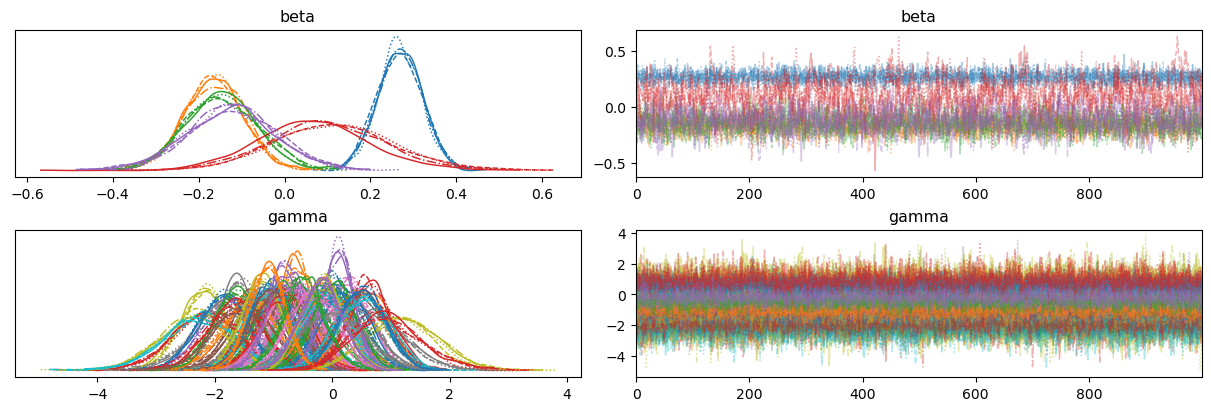

In [ ]:
az.plot_trace(idata_gambia_3, var_names=["beta", "gamma"], backend_kwargs={"layout": "constrained"});

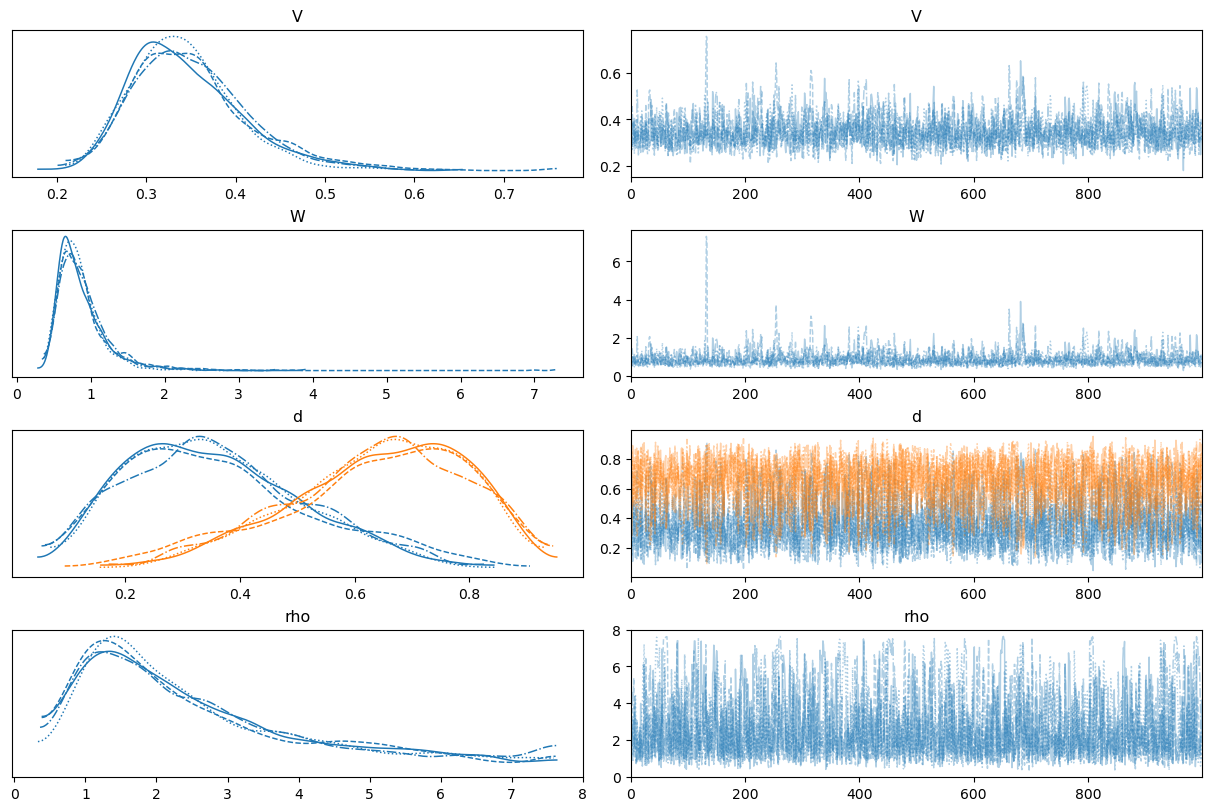

In [ ]:
az.plot_trace(idata_gambia_3, var_names=["V", "W", "d", "rho"], backend_kwargs={"layout": "constrained"});

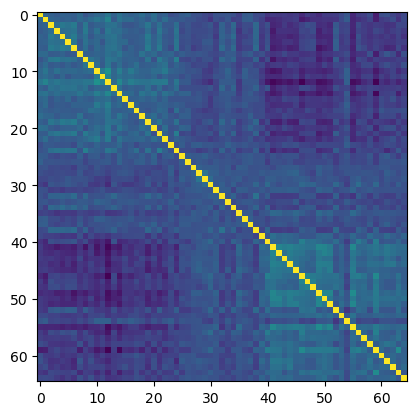

In [ ]:
corr_matrix = np.corrcoef(idata.posterior.gamma.stack(sample=("chain", "draw")).to_numpy())

fig, ax = plt.subplots()
ax.imshow(corr_matrix)

In [24]:
np.linalg.eigvals(corr_matrix)

array([7.05978755, 3.20229614, 1.77762577, 1.60898189, 1.33593258,
       1.2740785 , 1.20026988, 1.15284859, 1.11950249, 1.10212079,
       0.52723111, 1.07822562, 1.0731924 , 1.05915084, 1.03806648,
       0.55813136, 1.03115305, 0.56787032, 1.01669354, 1.00478555,
       0.58249182, 0.98987154, 0.98390139, 0.97444636, 0.59957437,
       0.60194364, 0.9592171 , 0.95157865, 0.93385857, 0.92906738,
       0.6146968 , 0.90901647, 0.90108644, 0.89122231, 0.8840551 ,
       0.87756188, 0.63374698, 0.64054942, 0.6522418 , 0.65447832,
       0.66400105, 0.86576229, 0.67120314, 0.85422766, 0.8456054 ,
       0.83096159, 0.6895    , 0.68892614, 0.69899696, 0.70031069,
       0.71242436, 0.72358105, 0.72750537, 0.81749052, 0.81204087,
       0.80944665, 0.80314406, 0.79432823, 0.74119411, 0.74964613,
       0.75529934, 0.7816034 , 0.76885796, 0.77112536, 0.77026687])

In [25]:
corr_matrix

array([[ 1.        ,  0.11014386,  0.08077044, ..., -0.05834275,
        -0.11048324, -0.04129186],
       [ 0.11014386,  1.        ,  0.09768453, ..., -0.01402523,
        -0.13320127, -0.03259148],
       [ 0.08077044,  0.09768453,  1.        , ..., -0.12589001,
        -0.03370113, -0.04453173],
       ...,
       [-0.05834275, -0.01402523, -0.12589001, ...,  1.        ,
         0.05582271,  0.13131   ],
       [-0.11048324, -0.13320127, -0.03370113, ...,  0.05582271,
         1.        ,  0.03443562],
       [-0.04129186, -0.03259148, -0.04453173, ...,  0.13131   ,
         0.03443562,  1.        ]], shape=(65, 65))